# Use pretrained model



In [2]:
from imcut import pycut
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from datetime import datetime

def make_data(sz=32, offset=0, sigma=80):
    seeds = np.zeros([sz, sz, sz], dtype=np.int8)
    seeds[offset + 12, offset + 9 : offset + 14, offset + 10] = 1
    seeds[offset + 20, offset + 18 : offset + 21, offset + 12] = 1
    img = np.ones([sz, sz, sz])
    img = img - seeds

    seeds[
        offset + 3 : offset + 15, offset + 2 : offset + 6, offset + 27 : offset + 29
    ] = 2
    img = scipy.ndimage.morphology.distance_transform_edt(img)
    segm = img < 7
    img = (100 * segm + sigma * np.random.random(img.shape)).astype(np.uint8)
    return img, segm, seeds
# make_data()


## Get the image data

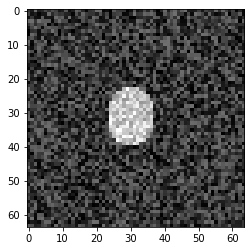

In [3]:
img, seg, seeds = make_data(64, 20)
i = 30
plt.imshow(img[i, :, :], cmap='gray')

## Prepare feature function with two features

In [9]:
def fv_function(data, voxelsize, seeds=None, cls=None):
    """
    Creates feature vector for only data or for data from classes
    """

    fv1 = data.reshape(-1, 1)

    data2 = scipy.ndimage.filters.gaussian_filter(data, sigma=0.1)
    fv2 = data2.reshape(-1, 1)

    fv = np.hstack([fv1, fv2])

    if seeds is not None:
        sd = seeds.reshape(-1, 1)
        selection = np.in1d(sd, cls)
        fv = fv[selection]
        sd = sd[selection]
        return fv, sd
    return fv


## Use external feature vector function

time cosumed=0:00:01.079115


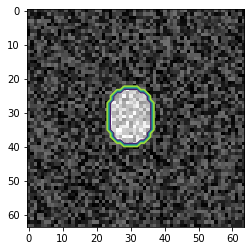

In [8]:
segparams = {
    # 'method':'graphcut',
    "method": "graphcut",
    "use_boundary_penalties": False,
    "boundary_dilatation_distance": 2,
    "boundary_penalties_weight": 1,
    "modelparams": {
        "type": "gmmsame",
        "fv_type": "fv_extern",
        "fv_extern": fv_function,
        "adaptation": "original_data",
    },
}
gc = pycut.ImageGraphCut(img, segparams=segparams)
gc.set_seeds(seeds)

gc.run()

plt.imshow(img[i, :, :], cmap='gray')
plt.contour(gc.segmentation[i,:,:])
plt.show()

## Run segmentation faster by loading model from file

The advantage is higher with the higher number of seeds.

time cosumed=0:00:00.716086


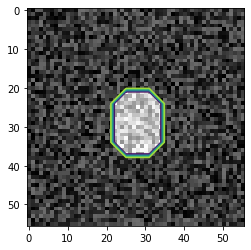

In [21]:
# forget
gc = None

img, seg, seeds = make_data(56, 18)
gc = pycut.ImageGraphCut(img)
gc.load(mdl_stored_file)
gc.set_seeds(seeds)

t0 = datetime.now()
gc.run(run_fit_model=False)
print(f"time cosumed={datetime.now()-t0}")

plt.imshow(img[i, :, :], cmap='gray')
plt.contour(gc.segmentation[i,:,:])
plt.show()


## The `seeds` does not have to be used if model is loaded from file

time cosumed=0:00:00.791880


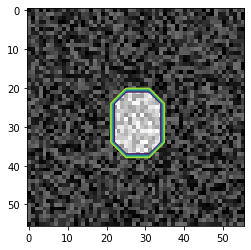

In [22]:
# forget
gc = None

img, seg, seeds = make_data(56, 18)
gc = pycut.ImageGraphCut(img)
gc.load(mdl_stored_file)

t0 = datetime.now()
gc.run(run_fit_model=False)
print(f"time cosumed={datetime.now()-t0}")

plt.imshow(img[i, :, :], cmap='gray')
plt.contour(gc.segmentation[i,:,:])
plt.show()
